# Lab Assignment Two: Exploring Image Data

### Luis Garduno

## 1. Business Understanding
#### <u>`About STL-10`</u>

Inspired by the
<a href="http://www.cs.toronto.edu/~kriz/cifar.html" target="_top"><b>CIFAR-10</b></a>
dataset, STL-10 is a dataset containing a combination of images (gathered from
<a href="http://www.image-net.org/" target="_top"><b>ImageNet</b></a>)
of animals and transportation objects. Within the dataset there are 6 animal & 4 transportation object classes:
- __Animals__ : bird, cat, deer, dog, horse, monkey
- __Transportation Objects__ : airplane, car, ship, truck

The dataset contains 3 folders that will be used at specified times:
- __Train__ : 5000 images used to train the algorithm
- __Test__ : 8000 images used to test an algorithm (800 images per class)
- __Unlabeled__ : 100,000 unlabeled image files

Aside from having not having identical classes, another difference between the datasets, is that the
images in STL-10 are 3x's the resolution of CIFAR-10's images (96x96 versus 32x32).

STL-10 is specifically an image recognition dataset. The dataset is intended to be used for developing
unsupervised feature learning, deep learning, self-taught algorithms. That being said, the primary prediction
task is to determine the type of animal or transportation object found in each of the pictures in the Unlabeled folder.
Something that should be noted about the "Unlabeled" folder, aside from it containing the the classes mentioned above,
it additionally includes other types of animals (bears, rabbits, etc.) and transportation objects[trains, buses, etc.).

#### <u>`Measuring Success`</u>

One reason this data is important is if trained correctly & the prediction task is achieved, third parties that
use image captcha's for their websites, networks, etc. could use this data as a way to visualize how captcha's can
be bypassed by __unsupervised__ feature learning, which essentially defeats the purpose of having a captcha test.

In order for this data to be of use to third parties using captcha's, I believe the prediction algorithm will
have to render at least an 80% accuracy. The reason it isn't 90% is because if the prediction algorithm selects a
wrong image, or doesn't recognize an image, often times captcha test's will let you get away with about 2 or less errors.

-------------------------------------
Dataset : <a href="https://www.kaggle.com/jessicali9530/stl10" target="_top"><b>STL-10 Kaggle Dataset</b></a>

Question Of Interest : Identify the type of animal or transportation object shown in the picture

----------------------------------------------

## 2. Data Preparation

###  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Loading Data & Adjustments

In [1]:
import glob
import pandas as pd
import numpy as np
from tkinter import Tcl
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

with open('./data/stl10_binary/train_y.bin', 'rb') as f:
    labels = np.fromfile(f, dtype=np.uint8)

with open('./data/stl10_binary/class_names.txt', 'r') as f:
    classNames = [line.rstrip() for line in f]

# Reading in the dataset (sorted by filename) into a numpy array
file_X = list(Tcl().call('lsort', '-dict', glob.glob('..\..\STL10\Train\*.png')))
rgb_matrix = np.array([np.array(Image.open(file)) for file in file_X])
_, h, w, c = rgb_matrix.shape

# Create new numpy array w/ re-colored greyscaled images
greyscale_matrix = np.array([np.array(Image.open(file).convert("L")) for file in file_X])

df = pd.DataFrame({'' : ['# of Samples','# of Features','Image Resolution','# of Channels','Image Size']})
df['Original Data']  = [_, h*w*c, '{} x {}'.format(h,w), c, str(h*w*c) + 'px\'s']
df['Greyscale Data']  = [_, h*w, '{} x {}'.format(h,w), 1, str(h*w) + 'px\'s']

rgb_vec = rgb_matrix.reshape((_,h*w*c))
greyscale_vec = greyscale_matrix.reshape((_,h*w))

print("\nOriginal Matrix Shape   :  Before", rgb_matrix.shape, "----->  After", rgb_vec.shape,"\n")
print("Greyscale Matrix Shape  :  Before", greyscale_matrix.shape, "   ----->  After",greyscale_vec.shape, "\n\n")

df


Original Matrix Shape   :  Before (5000, 96, 96, 3) ----->  After (5000, 27648) 

Greyscale Matrix Shape  :  Before (5000, 96, 96)    ----->  After (5000, 9216) 




Original Data Greyscale Data
0      # of Samples          5000           5000
1     # of Features         27648           9216
2  Image Resolution       96 x 96        96 x 96
3     # of Channels             3              1
4        Image Size     27648px's       9216px's

We begin by reading the dataset into a numpy array, but because it contains colored images, it would be optimal
to turn it into a grayscale array so we are able to compute faster.

Then after doing so, the shape of the original matrix and grayscale are outputted to show the initial dimensions.
To the right of these shapes, are the concatenated versions of those matrices.

At the bottom a table is created to better understand the differences between the 2 matrices, one containing color
pictures and the other one containing greyscaled images. Here, is where we notice the large distance between the image
sizes for each matrix. Notice how each greyscaled picture is 3 times smaller than the original color pictures.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Visualizing Images

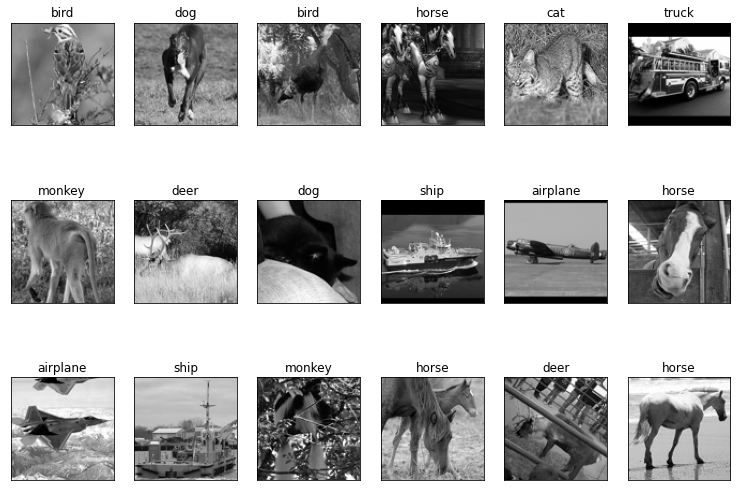

In [2]:
def plot_gallery(images, titles, h, w, flag, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.25)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        if flag:
            plt.title(classNames[titles[i] - 1], size=12)
        if not flag:
            plt.title(titles[i], size=12)
        plt.xticks(());  plt.yticks(())

plot_gallery(greyscale_vec, labels, h, w, True)

Here we visualize 18 images within the greyscale numpy array. This function will be helpful later
on to output certain images given a certain certain array.

----------------------------

## 3. Data Reduction
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Linear Dimensionality Reduction

In [3]:
from sklearn.decomposition import PCA

# We use the function plot_explained_variance to help us visualize the explained variance
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_ * 100
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='Individual explained variance'),
                 Scatter(y=cum_var_exp, name='Cumulative explained variance')],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Variance Explained (%)'))
    })

# This function will help us later on to reconstruct the PCA/RPCA into an image
def reconstruct_image(trans_obj, org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.1 PCA [35 points]

In [4]:
n_components = 350
print("Extracting the top %d eigenObjects from %d Objects" % (n_components, greyscale_vec.shape[0]))
pca = PCA(n_components=n_components)
%time pca.fit(greyscale_vec.copy())
eigenObjects = pca.components_.reshape((n_components,h,w))
plot_explained_variance(pca)

Extracting the top 350 eigenObjects from 5000 Objects
Wall time: 14.8 s


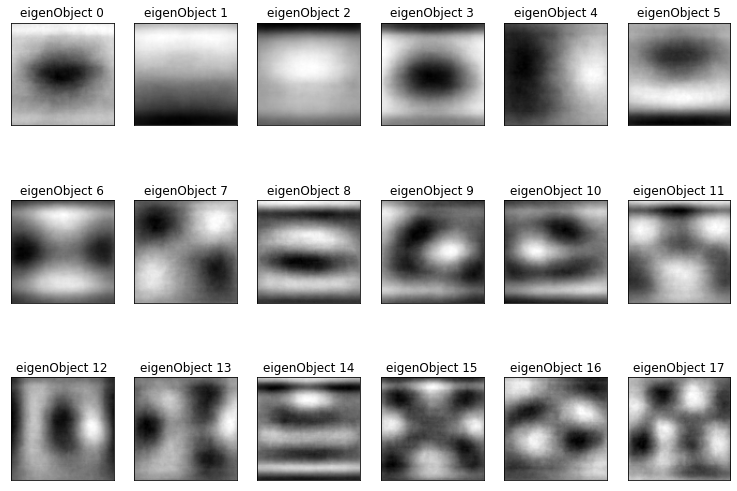

In [5]:
eigenObject_titles = ["eigenObject %d" % i for i in range(eigenObjects.shape[0])]
plot_gallery(eigenObjects, eigenObject_titles, h, w, False)

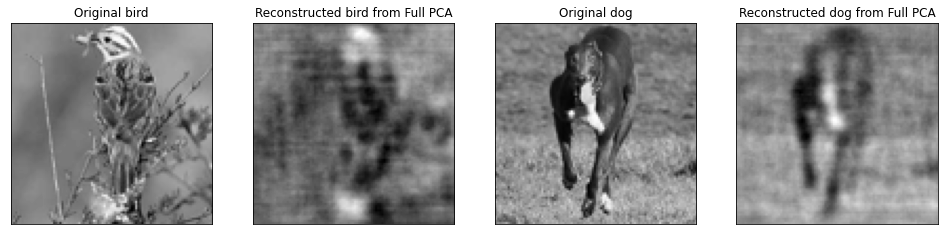

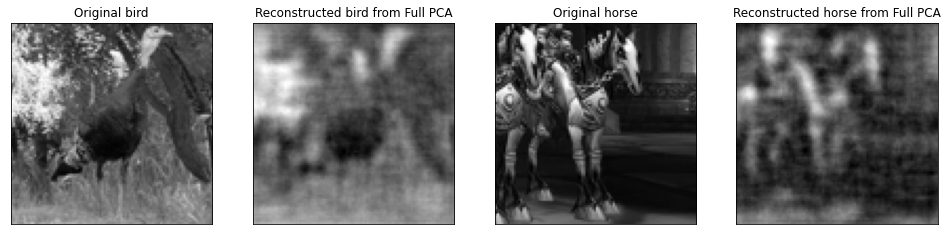

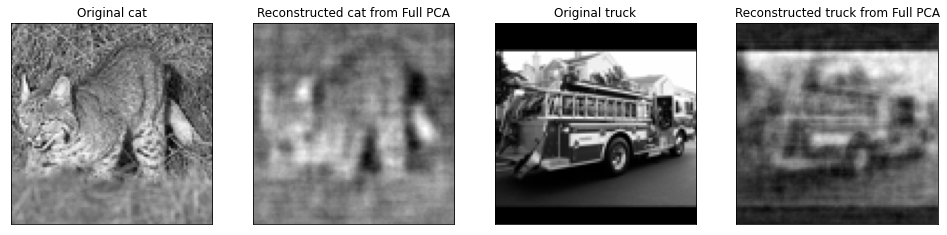

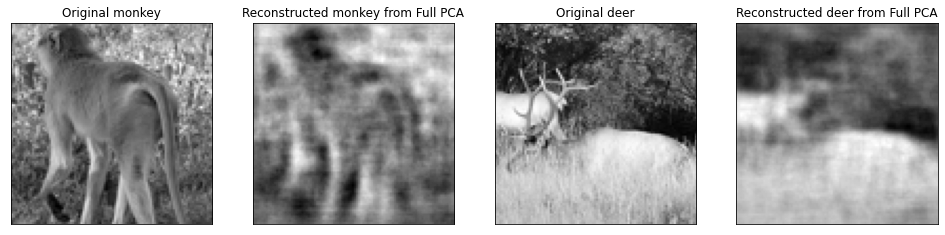

In [6]:
c = pic = 0
plt.figure(figsize=(20, 5))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.25)
for i in range (0, 8):
    eigenObjects_idx = greyscale_vec[i]
    low_dim_rep_pca, reconstruct_img_pca = reconstruct_image(pca, eigenObjects_idx.reshape(1,-1))
    obj = classNames[labels[pic] - 1]

    plt.subplot(1,6,c+1)
    plt.imshow(eigenObjects_idx.reshape((h,w)), cmap=plt.cm.gray)
    plt.title('Original ' + obj)
    plt.grid(False)
    plt.xticks(()); plt.yticks(())

    plt.subplot(1,6,c+2)
    plt.imshow(reconstruct_img_pca.reshape((h,w)), cmap=plt.cm.gray)
    plt.title('Reconstructed ' + obj +' from Full PCA')
    plt.grid(False)
    plt.xticks(()); plt.yticks(())

    c += 2; pic += 1

    if c == 4:
        if i != 7:
            plt.figure(figsize=(20,5))
            plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.25)
        c = 0

- Analyze how many dimensions are required to adequately represent your image data
- Explain your analysis and conclusion

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.2 Randomized PCA [40 points]

Extracting the top 350 eigenObjects from 5000 Objects
Wall time: 15 s


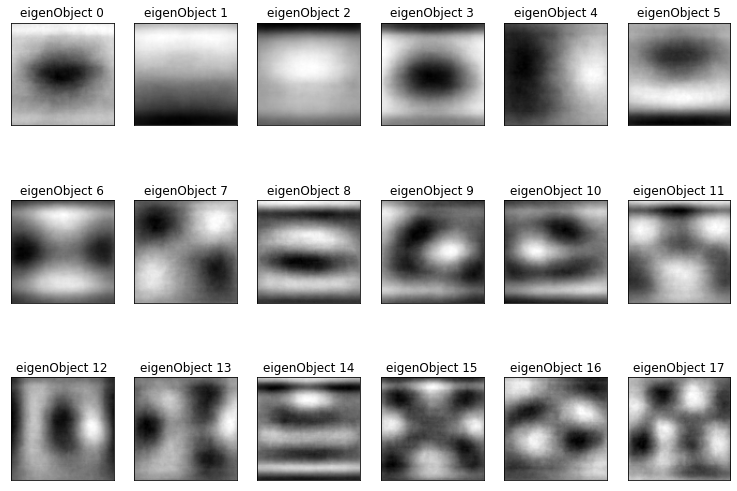

In [7]:
n_components = 350
print("Extracting the top %d eigenObjects from %d Objects" % (n_components, greyscale_vec.shape[0]))
rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(greyscale_vec.copy())
eigenObjects = rpca.components_.reshape((n_components,h,w))

eigenObject_titles = ["eigenObject %d" % i for i in range(eigenObjects.shape[0])]
plot_gallery(eigenObjects, eigenObject_titles, h, w, False)

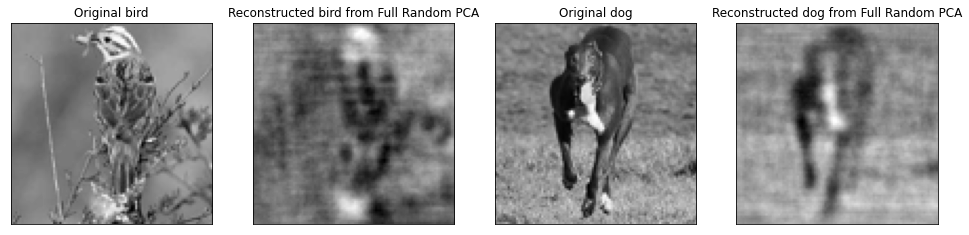

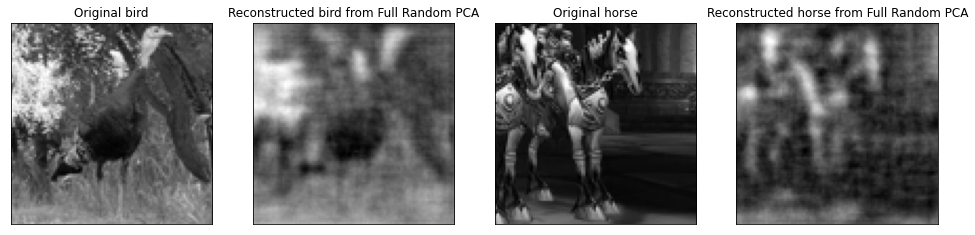

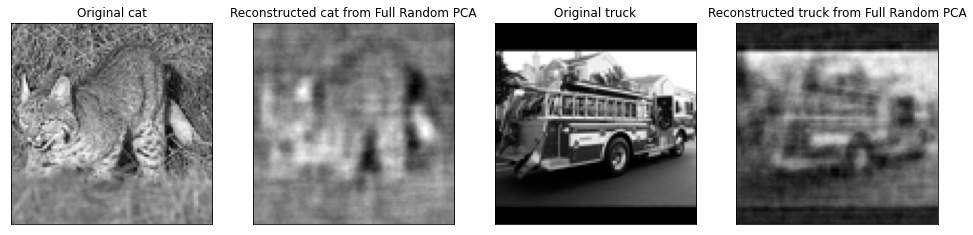

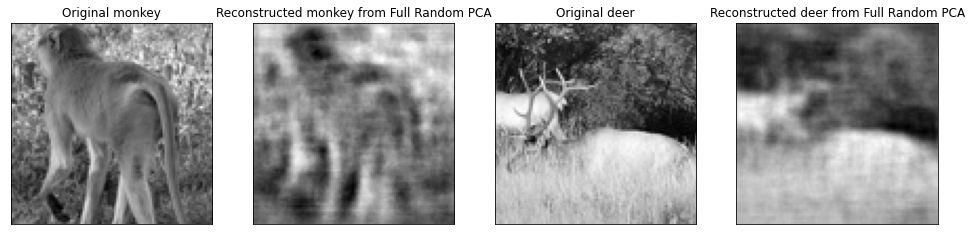

In [8]:
c = pic = 0
plt.figure(figsize=(20, 5))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.25)
for i in range (0, 8):
    eigenObjects_idx = greyscale_vec[i]
    low_dim_rep_rpca, reconstruct_img_rpca = reconstruct_image(rpca, eigenObjects_idx.reshape(1,-1))
    obj = classNames[labels[pic] - 1]

    plt.subplot(1,6,c+1)
    plt.imshow(eigenObjects_idx.reshape((h,w)), cmap=plt.cm.gray)
    plt.title('Original ' + obj)
    plt.grid(False)
    plt.xticks(()); plt.yticks(())

    plt.subplot(1,6,c+2)
    plt.imshow(reconstruct_img_rpca.reshape((h,w)), cmap=plt.cm.gray)
    plt.title('Reconstructed ' + obj +' from Full Random PCA')
    plt.grid(False)
    plt.xticks(()); plt.yticks(())

    c += 2; pic += 1

    if c == 4:
        if i != 7:
            plt.figure(figsize=(20,5))
            plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.25)
        c = 0

- Analyze how many dimensions are required to adequately represent your image data
- Explain your analysis and conclusion

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.3 PCA vs Randomized PCA [60 points]

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
%time pca.fit(greyscale_vec)
greyscale_pca = pca.transform(greyscale_vec)
pca_proj = pca.inverse_transform(greyscale_pca)
loss = ((greyscale_vec - pca_proj) ** 2).mean()
print(loss)

rpca = PCA(n_components=400, svd_solver='randomized')
%time rpca.fit(greyscale_vec)
greyscale_rpca = rpca.transform(greyscale_vec)
rpca_proj = rpca.inverse_transform(greyscale_rpca)
loss = ((greyscale_vec - rpca_proj) ** 2).mean()
print(loss)

# Compare the representation using __PCA__ & __Randomized PCA__.
# The method I choose to compare dimensionality methods should quantitatively explain which method
# is better at representing the images w/ fewer components.

Wall time: 16.7 s
350.59160997273017
Wall time: 16.6 s
350.61813259341227


Do you prefer one method over another?
Why?

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Feature Extraction [70 points]

In [10]:
# Perform feature extraction upon the images using any feature extraction technique (e.g. gabor
# filters, ordered gradients, DAISY, etc.).

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Visualizing Feature Extraction efficiency [90 points]
    - Does this feature extraction method show promise for your prediction task? Why?
    - Use visualizations to analyze this questions.
    - Example : Visualize the difference __between statistics of extracted features__ in each target class.
    - Example : Use a heat map of the pairwise differences (ordered by class) among all extracted features.
    - Example : build a nearest neighbor classifier to see actual classification performance.


#### References

Kaggle. STL-10. https://www.kaggle.com/jessicali9530/stl10 (Accessed 9-25-2020)

Adam Coates, Honglak Lee, Andrew Y. Ng An Analysis of Single Layer Networks in Unsupervised Feature Learning AISTATS, 2011.
